In [0]:
number_of_epochs=10   # Set here number of epochs you want for RNN and LSTM

feature_to_predict='PS' # Set here abbreviation of feature you want to predict
# Details of features are described below:
	# Temperature at 2 Meters (C) (T2M)
	# Dew/Frost Point at 2 Meters (C) (T2MDEW)
	# Wet Bulb Temperature at 2 Meters (C) (T2MWET)
	# Specific Humidity at 2 Meters (g/kg) (QV2M)
	# Precipitation Corrected (mm/day) (PRECTOTCORR)
	# Surface Pressure (kPa) (PS)
	# Wind Speed at 10 Meters (m/s) (WS10M)
	# Wind Direction at 10 Meters (Degrees) (WD10M)
	# Wind Speed at 50 Meters (m/s) (WS50M)
	# Wind Direction at 50 Meters (Degrees) (WD50M)
	# Relative Humidity at 2 Meters (%) (RH2M)
	# Earth Skin Temperature (C) (TS)

batchSize=16 # Set here batch size neural networks need to process
learningRate=0.001 # Set here learning rate
hiddenLayerDimension=50 # Set here dimension of hidden layer of neural networks

In [0]:
!pip install -U scikit-learn

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-69784471-7eda-4d2d-af0a-1b19b8163a8d/bin/python -m pip install --upgrade pip' command.


In [0]:
!pip install -U matplotlib

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-69784471-7eda-4d2d-af0a-1b19b8163a8d/bin/python -m pip install --upgrade pip' command.


In [0]:
from pyspark.ml.feature import MinMaxScaler,VectorAssembler
from pyspark.sql.functions import udf,col
from pyspark.sql.types import DoubleType
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler as mmscaler
import matplotlib

In [0]:
class LSTM:
    # Constructor for LSTM class
    def __init__ (self, inp_dim, out_dim, batch_size, alpha):
        self.data_in = np.zeros(inp_dim + out_dim)   # Data : input data
        self.data_out = np.zeros(shape = (1, out_dim))  # Data : output data
        self.batch_size = batch_size  # Hyperparam : batch size
        self.cell_state_vals = np.zeros(out_dim)
        self.alpha = alpha  # Hyperparam : learning rate
        self.input_weight_mat = np.random.random((out_dim, inp_dim + out_dim))   # input weights
        self.forget_weight_mat = np.random.random((out_dim, inp_dim + out_dim))  # forget weights
        self.output_weight_mat = np.random.random((out_dim, inp_dim + out_dim))  # output weights
        self.activation_weight_mat = np.random.random((out_dim, inp_dim + out_dim))  # activation weights
        self.update_forget_weight_mat = np.zeros_like(self.forget_weight_mat)
        self.update_input_weight_mat = np.zeros_like(self.input_weight_mat)
        self.update_activation_weight_mat = np.zeros_like(self.activation_weight_mat)
        self.update_output_weight_mat = np.zeros_like(self.output_weight_mat)

    # Helper Function 1 - Implementation of Sigmoid activation function
    def sigmoid(self, inp):
        val = 1 / (1 + np.exp(-inp))
        return val
    
    # Helper Function 2 - Implementation of Derivative of Sigmoid function
    def sigmoid_der(self, inp):
        der = self.sigmoid(inp) * (1 - self.sigmoid(inp))
        return der
    
    # Helper Function 3 - Implementation of Derivative of hyperbolic tangent
    def tanh_der(self, inp):
        return 1 - np.tanh(inp) * np.tanh(inp)

    # forward pass
    def fwd_pass(self):
        input_value = self.sigmoid(np.dot(self.input_weight_mat, self.data_in))
        forget_value = self.sigmoid(np.dot(self.forget_weight_mat, self.data_in))
        output_value = self.sigmoid(np.dot(self.output_weight_mat, self.data_in))
        activation_value = np.tanh(np.dot(self.activation_weight_mat, self.data_in))
        self.cell_state_vals = self.cell_state_vals*forget_value + (activation_value*input_value)
        self.data_out = output_value * np.tanh(self.cell_state_vals)

        return self.cell_state_vals, self.data_out, forget_value, input_value, activation_value, output_value

    # backward pass
    def bwd_pass(self, err_RNN, prev_cell_state, forget_value, input_value, activation_value, output_value, del_cell_state, del_hidden_state):
        err_RNN = err_RNN + del_hidden_state
        der_output = np.tanh(self.cell_state_vals) * err_RNN
        der_cell_state = err_RNN * output_value * self.tanh_der(self.cell_state_vals) + del_cell_state
        del_prev_cell_state = der_cell_state * forget_value
        der_forget_val = der_cell_state * prev_cell_state
        der_input_val = der_cell_state * activation_value
        der_activation_val = der_cell_state * input_value

        in_2d = np.atleast_2d(self.data_in)
        out_val = np.atleast_2d(der_output * self.sigmoid_der(output_value)).T
        del_output_val = np.dot(out_val, in_2d)
        forget_val = np.atleast_2d(der_forget_val * self.sigmoid_der(forget_value)).T
        del_forget_val = np.dot(forget_val, in_2d)
        in_val = np.atleast_2d(der_input_val * self.sigmoid_der(input_value)).T
        del_input_val = np.dot(in_val , in_2d)
        act_val = np.atleast_2d(der_activation_val * self.tanh_der(activation_value)).T
        del_activation_val = np.dot(act_val, in_2d)
        del_prev_hidden_state = np.dot(der_activation_val, self.activation_weight_mat)[:self.data_out.shape[0]]+ np.dot(der_output, self.output_weight_mat)[:self.data_out.shape[0]]+ np.dot(der_input_val, self.input_weight_mat)[:self.data_out.shape[0]]+ np.dot(der_forget_val, self.forget_weight_mat)[:self.data_out.shape[0]]

        return del_forget_val, del_input_val, del_activation_val, del_output_val, del_prev_cell_state, del_prev_hidden_state

    def update_weight_mat(self, del_forget_val, del_input_val, del_activation_val, del_output_val):
        self.update_forget_weight_mat = 0.85 * self.update_forget_weight_mat + 0.15 * del_forget_val * del_forget_val
        self.update_input_weight_mat = 0.85 * self.update_input_weight_mat + 0.15 * del_input_val * del_input_val
        self.update_activation_weight_mat = 0.85 * self.update_activation_weight_mat + 0.15 * del_activation_val * del_activation_val
        self.update_output_weight_mat = 0.85 * self.update_output_weight_mat + 0.15 * del_output_val * del_output_val

        self.forget_weight_mat -= self.alpha/np.sqrt(np.power(10.0, -8) + self.update_forget_weight_mat) * del_forget_val
        self.input_weight_mat -= self.alpha/np.sqrt(np.power(10.0, -8) + self.update_input_weight_mat) * del_input_val
        self.activation_weight_mat -= self.alpha/np.sqrt(np.power(10.0, -8) + self.update_activation_weight_mat) * del_activation_val
        self.output_weight_mat -= self.alpha/np.sqrt(np.power(10.0, -8) + self.update_output_weight_mat) * del_output_val

In [0]:
class RNN:
    # Constructor for RNN class
    def __init__ (self, x_inp, actual_op, hid_layer_dim, alpha, batch_size):

        # Data : input data
        self.x_inp = x_inp
        # Data : actual output
        self.actual_op = actual_op
        # Hyperparam : hidden layer size
        self.hid_layer_dim = hid_layer_dim
        # Hyperparam : learning rate
        self.alpha = alpha
        # Hyperparam : batch size
        self.batch_size = batch_size
        # input dimentions : number of input features
        self.inp_dim = x_inp.shape[1]
        # output dimension : number of output features
        self.op_dim = 1

        # 
        self.d_weight_mat = np.random.random(( self.op_dim, self.hid_layer_dim))
        # 
        self.updated_weight_mat = np.zeros_like(self.d_weight_mat)

        # 
        self.cell_state_vals = np.zeros(( self.batch_size+1, self.hid_layer_dim))
        # 
        self.predicted_outputs = np.zeros(( self.batch_size+1, self.op_dim))
        # 
        self.hid_state_vals = np.zeros(( self.batch_size+1, self.hid_layer_dim))

        # 
        self.forgetg_vals = np.zeros(( self.batch_size+1, self.hid_layer_dim))
        # 
        self.inputg_vals = np.zeros(( self.batch_size+1, self.hid_layer_dim))
        # 
        self.actg_vals = np.zeros(( self.batch_size+1, self.hid_layer_dim))
        # 
        self.outputg_vals = np.zeros(( self.batch_size+1, self.hid_layer_dim))

        # 
        self.d_weight_add = 1e-9
        self.grad_fact = 0.950
        self.diff_fact = 0.10
        # 
        self.LSTM = LSTM(self.inp_dim, self.hid_layer_dim, self.batch_size, self.alpha)

    # Helper Function 1 - Implemention of Sigmoid activation function 
    def sigmoid(self, inp):
        val = 1 / (1 + np.exp(-inp))
        return val

    # Helper Function 2 - Implemention of Derivative of Sigmoid function 
    def sigmoid_der(self, inp):
        der = self.sigmoid(inp) * (1 - self.sigmoid(inp))
        return der

    # Helper Function 3 - To update weights of weight matrix
    def update_weights(self, diff):
        self.updated_weight_mat = self.grad_fact * self.updated_weight_mat + self.diff_fact  * np.power(diff, 2)
        gradientVal = self.updated_weight_mat + self.d_weight_add
        self.d_weight_mat -= self.alpha/np.sqrt(gradientVal) * diff

    # 
    def fwd_pass(self, batch_x_inp):

        # 
        for t in range(1, batch_x_inp.shape[0]):
            # 
            self.LSTM.data_in = np.hstack((self.hid_state_vals[t-1], batch_x_inp[t]))

            cell_state_val, hidden_state_val, forgetg_val, inputg_val, actg_val, outputg_val = self.LSTM.fwd_pass()

            # 
            self.cell_state_vals[t] = cell_state_val
            self.hid_state_vals[t] = hidden_state_val
            self.forgetg_vals[t] = forgetg_val
            self.inputg_vals[t] = inputg_val
            self.actg_vals[t] = actg_val
            self.outputg_vals[t] = outputg_val
            # 
            self.predicted_outputs[t] = self.sigmoid(np.dot(self.d_weight_mat, hidden_state_val))

        return self.predicted_outputs

    # 
    def bwd_pass(self, actual_batch_output, batch_x_inp):
        # 
        total_batch_error = 0
        # 
        cell_state_diff = np.zeros(self.hid_layer_dim)
        # 
        hidden_state_diff = np.zeros(self.hid_layer_dim)

        # 
        weight_difference = np.zeros(( self.op_dim, self.hid_layer_dim))
        # 
        total_forgetg_diff = np.zeros(( self.hid_layer_dim, self.inp_dim+self.hid_layer_dim))
        # 
        total_inputg_diff = np.zeros(( self.hid_layer_dim, self.inp_dim+self.hid_layer_dim))
        # 
        total_actg_diff = np.zeros(( self.hid_layer_dim, self.inp_dim+self.hid_layer_dim))

        total_outputg_diff = np.zeros(( self.hid_layer_dim, self.inp_dim+self.hid_layer_dim))

        # 
        for t in range(self.batch_size-1, -1, -1):
            # 
            curr_error = abs(self.predicted_outputs[t] - actual_batch_output[t])
            # 
            total_batch_error += curr_error
            # 
            weight_difference += np.dot(np.atleast_2d(curr_error * self.sigmoid_der(self.predicted_outputs[t])),
                                        np.atleast_2d(self.hid_state_vals[t]))

            # 
            lstm_error = np.dot(curr_error, self.d_weight_mat)
            # 
            self.LSTM.data_in = np.hstack((self.hid_state_vals[t-1], batch_x_inp[t]))
            # 
            self.LSTM.cell_state_vals = self.cell_state_vals[t]
            # 
            forgetg_diff, inputg_diff, actg_diff, outputg_diff, cell_state_diff, hidden_state_diff = self.LSTM.bwd_pass(lstm_error, self.cell_state_vals[t-1], self.forgetg_vals[t], self.inputg_vals[t], self.actg_vals[t], self.outputg_vals[t], cell_state_diff, hidden_state_diff)

            # 
            total_forgetg_diff += forgetg_diff
            # 
            total_inputg_diff += inputg_diff
            # 
            total_actg_diff += actg_diff
            # 
            total_outputg_diff += outputg_diff

            # 
        self.LSTM.update_weight_mat(total_forgetg_diff/self.batch_size, total_inputg_diff/self.batch_size, total_actg_diff/self.batch_size, total_outputg_diff/self.batch_size)
            # 
        self.update_weights(weight_difference/self.batch_size)

        return total_batch_error

    

    # 
    def test(self, batch_x_inp, batch_y_op):

        # 
        batch_size = batch_x_inp.shape[0]
        # 
        self.acualOutput = batch_y_op
        # 
        self.cell_state_vals = np.zeros(( batch_size+1, self.hid_layer_dim))
        # 
        self.predicted_outputs = np.zeros(( batch_size+1, self.op_dim))
        # 
        self.hid_state_vals = np.zeros(( batch_size+1, self.hid_layer_dim))
        # 
        self.forgetg_vals = np.zeros(( batch_size+1, self.hid_layer_dim))
        # 
        self.inputg_vals = np.zeros(( batch_size+1, self.hid_layer_dim))
        # 
        self.actg_vals = np.zeros(( batch_size+1, self.hid_layer_dim))
        # 
        self.outputg_vals = np.zeros(( batch_size+1, self.hid_layer_dim))

        # 
        total_test_error = 0

        for t in range(1, batch_size):

            # 
            self.LSTM.data_in = np.hstack((self.hid_state_vals[t-1], batch_x_inp[t]))

            cell_state_val, hidden_state_val, forgetg_val, inputg_val, actg_val, outputg_val = self.LSTM.fwd_pass()

            # 
            self.cell_state_vals[t] = cell_state_val
            self.hid_state_vals[t] = hidden_state_val
            self.forgetg_vals[t] = forgetg_val
            self.inputg_vals[t] = inputg_val
            self.actg_vals[t] = actg_val
            self.outputg_vals[t] = outputg_val

            # 
            self.predicted_outputs[t] = self.sigmoid(np.dot(self.d_weight_mat, hidden_state_val))

            curr_error = abs(self.predicted_outputs[t] - batch_y_op[t])
            total_test_error += curr_error

        return self.predicted_outputs, total_test_error

In [0]:
# Driver Code

# Loading the data
df=spark.read.option("header","true").option('inferSchema','true').csv('dbfs:/FileStore/tables/dataset.csv')

# Select feature to predict
df1=df.select(feature_to_predict)

# Normalizing the data
assembler=VectorAssembler().setInputCols([feature_to_predict]).setOutputCol('featurevector')
assembled=assembler.transform(df1)

scaler=MinMaxScaler().setInputCol('featurevector')
scalerModel=scaler.fit(assembled)
scalerModel.setOutputCol('featurescaled')
scaled=scalerModel.transform(assembled)

# Extracting values from dense vectors
extractor_udf=udf(lambda x:float(sum(x)),DoubleType())
transformed=scaled.withColumn('feature',extractor_udf(col('featurescaled')))

# Splitting the dataset into training and testing dataset
train, test = transformed.randomSplit([0.8,0.2],seed=500)

# Splitting training and testing data into features and label to make it comfortable for supervised learning

X_train_temp=[]
y_train_temp=[]
X_test_temp=[]
y_test_temp=[]
train_collect=train.rdd.map(lambda x:x['feature']).collect()
test_collect=test.rdd.map(lambda x:x['feature']).collect()

for i in range(50,len(train_collect)):
    X_train_temp.append(train_collect[i-50:i])
    y_train_temp.append(train_collect[i])
for j in range(50,len(test_collect)):
    X_test_temp.append(test_collect[j-50:j])
    y_test_temp.append(test_collect[j])

X_train=np.array(X_train_temp)
y_train=np.array(y_train_temp)
X_test=np.array(X_test_temp)
y_test=np.array(y_test_temp)

In [0]:
# Initialization of RNN
rnn = RNN(X_train, y_train, hiddenLayerDimension, learningRate, batchSize)

In [0]:
# Training of RNN

sklearn_scaler=mmscaler(feature_range = (0, 1))

for epoch in range(number_of_epochs):
    first_row = 0
    rnn.batch_size=batchSize
    last_row=batchSize 
    total_training_error = 0
    prediction_for_training_temp=np.array([])

    if X_train.shape[0]>=batchSize:                                
        while True:
            prediction_for_training_temp=np.append(prediction_for_training_temp,rnn.fwd_pass(X_train[first_row : last_row])[1:])
            total_training_error  += rnn.bwd_pass(y_train[first_row : last_row], X_train[first_row : last_row])
            first_row = last_row
            last_row+=batchSize
            if last_row>=X_train.shape[0]:
                rnn.batch_size=X_train.shape[0]-first_row
                prediction_for_training_temp=np.append(prediction_for_training_temp,rnn.fwd_pass(X_train[first_row : X_train.shape[0]])[1:X_train.shape[0]-first_row+1])
                total_training_error  += rnn.bwd_pass(y_train[first_row : X_train.shape[0]], X_train[first_row : X_train.shape[0]])
                break
    else:
        rnn.batch_size=X_train.shape[0]-first_row
        prediction_for_training_temp=np.append(prediction_for_training_temp,rnn.fwd_pass(X_train[first_row : X_train.shape[0]])[1:X_train.shape[0]-first_row+1])
        total_training_error  += rnn.bwd_pass(y_train[first_row : X_train.shape[0]], X_train[first_row : X_train.shape[0]])
    
    obj=sklearn_scaler.fit(np.array(df1.rdd.map(lambda x:x[feature_to_predict]).collect()).reshape(-1,1))
    prediction_for_training = (obj.inverse_transform(prediction_for_training_temp.reshape(-1,1)))[:,0]             
    gold_label_y_train = obj.inverse_transform(y_train.reshape(-1,1))
    r2=r2_score(gold_label_y_train,prediction_for_training)
    print("R2 score for training for epoch {}:{}".format(epoch+1,r2))
    print("Training error for epoch {}:{}".format(epoch+1,total_training_error[0]))
    print("Root Mean Square error for training for epoch {}:{}".format(epoch+1,np.sqrt(mean_squared_error(gold_label_y_train,prediction_for_training))))

R2 score for training for epoch 1:-16.073309426681043
Training error for epoch 1:5582.844529750471
Root Mean Square error for training for epoch 1:2.394391329807125
R2 score for training for epoch 2:-16.073309426681043
Training error for epoch 2:5582.844529750471
Root Mean Square error for training for epoch 2:2.394391329807125
R2 score for training for epoch 3:-16.073309426681043
Training error for epoch 3:5582.844529750471
Root Mean Square error for training for epoch 3:2.394391329807125
R2 score for training for epoch 4:-16.073309426681043
Training error for epoch 4:5582.844529750471
Root Mean Square error for training for epoch 4:2.394391329807125
R2 score for training for epoch 5:-16.073309426681043
Training error for epoch 5:5582.844529750471
Root Mean Square error for training for epoch 5:2.394391329807125
R2 score for training for epoch 6:-16.073309426681043
Training error for epoch 6:5582.844529750471
Root Mean Square error for training for epoch 6:2.394391329807125
R2 score f

In [0]:
# Testing of RNN

prediction_for_testing_temp, testing_error = rnn.test(X_test, y_test)
prediction_for_testing = (sklearn_scaler.inverse_transform(prediction_for_testing_temp[1:]))[:,0]                                            
gold_label_y_test = sklearn_scaler.inverse_transform(y_test.reshape(-1,1))
r2=r2_score(gold_label_y_test,prediction_for_testing)
print("R2 score for testing:{}".format(r2))
print("Testing error:{}".format(testing_error[0]))
print("Root Mean Square error for testing:{}".format(epoch+1,np.sqrt(mean_squared_error(gold_label_y_test,prediction_for_testing))))

R2 score for testing:-18.019529133576647
Testing error:1360.6142034548966
Root Mean Square error for testing:10


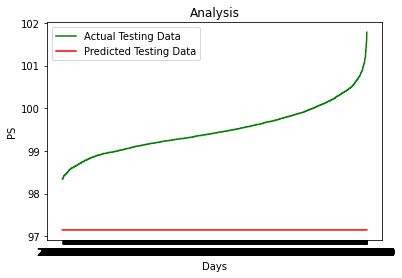

In [0]:
# Analysis

x_data=df.rdd.map(lambda x:str(x['YEAR'])+"-"+str(x['MO'])+"-"+str(x['DY'])).collect()

matplotlib.pyplot.plot(x_data[train.count()+50:],gold_label_y_test,label="Actual Testing Data",color="g")
matplotlib.pyplot.plot(x_data[train.count()+50:],prediction_for_testing,label="Predicted Testing Data",color="r")

matplotlib.pyplot.xlabel("Days")
matplotlib.pyplot.ylabel(feature_to_predict)
matplotlib.pyplot.title("Analysis")

matplotlib.pyplot.legend()
matplotlib.pyplot.show()